In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader
import time


**Načítanie datasetov**

---


 train: Toxic Tweets Dataset;
 test: Wikipedia dataset

In [ ]:
test = pd.read_csv('wiki.csv')
train = pd.read_csv('data2.csv')

In [ ]:
test = test.drop('id', axis=1)
test = test.rename(columns={'comment_text': 'tweet'})
test = test.rename(columns={'toxic': 'class'})


In [ ]:
# Rozdelenie trénovacích dát na textové komentáre a zodpovedajúce triedy
train_texts = train['tweet']
train_labels = train['Toxicity']
test_texts = test['tweet']
test_labels = test['class']


In [ ]:
# Načítanie predtrénovanej BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Načítanie predtrénovanej BERT modelu pre klasifikáciu sekvencií
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenizácia textových komentárov a príprava dát pre trénovanie
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# Vytvorenie trénovacieho datasetu z tokenizovaných dát
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels.tolist()))

# Vytvorenie testovacieho datasetu z tokenizovaných dát
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels.tolist()))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
try:
    # Trénovanie modelu
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # Určenie zariadenia (GPU alebo CPU) na trénovanie modelu
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.train()

    # Definícia optimalizátora pre trénovanie modelu
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    # Trénovanie modelu počas 3 epoch
    for epoch in range(3):
        start_time = time.time()  # Uloženie času začiatku epochy
        print(f"Epócha {epoch + 1} z 3")
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        end_time = time.time()  # Uloženie času konca epochy
        epoch_time = end_time - start_time  # Výpočet času stráveného na epóche
except Exception as e:
    # Spracovanie a výpis informácií o chybe, ak sa vyskytne
    print("Došlo k chybe:", e)


In [ ]:
# Testovanie modelu
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Prepínanie modelu do režimu vyhodnocovania
model.eval()

# Inicializácia premenných pre predikcie a skutočné triedy
all_preds = []
all_labels = []

for batch in test_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].cpu().numpy()
    # Výpočet predikcií modelu
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    # Zaznamenanie predikcií a skutočných tried
    all_preds.extend(preds)
    all_labels.extend(labels)

# Vyhodnotenie výsledkov
accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy:", accuracy)


Accuracy: 0.8694


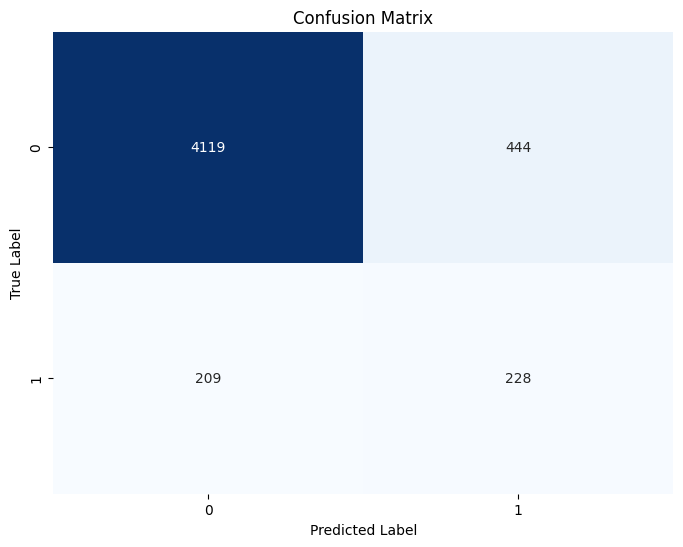

In [ ]:
# Výpočet confusion matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
def false_negative_rate(false_negatives, true_positives):
    return false_negatives / (false_negatives + true_positives)
# Vypočítanie falošných negatív
false_negatives = cm[1][0]
print(false_negatives)
# Vypočítanie počtu skutočných pozitív
true_positives = cm[1][1]
print(true_positives)
# Výpočet falošnej negatívnej miery
fnr = false_negative_rate(false_negatives, true_positives)

print("Falošná negatívna miera:", fnr)

209
228
Falošná negatívna miera: 0.4782608695652174
